In [ ]:
import nltk, csv, string, random, os, pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.classify import NaiveBayesClassifier, accuracy
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
ENGLISH_STOPWORDS = stopwords.words('english')
PUNCTUATIONS = string.punctuation
LEMMATIZER = WordNetLemmatizer()
STEMMER = PorterStemmer()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Project-NLP/train-balanced-sarcasm-50k.csv")

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,label,comment
0,0,Schefter also said Cook is signing with Stl......
1,1,Yup every catholic does that
2,1,Glad you watched the video.
3,0,You can't be forced to make movies.
4,1,"Go make your own sub, I'm suuure it is necessa..."


In [ ]:
df['label'].value_counts()

label
1    25095
0    24905
Name: count, dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
def clean(tweet):
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)

    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)

    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)

    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)

    #Punctuations and special characters
    tweet = re.sub('[%s]' % re.escape(PUNCTUATIONS),'',tweet)

    tweet = tweet.lower()

    splits = tweet.split()
    splits = [word for word in splits if word not in set(ENGLISH_STOPWORDS)]
    tweet = ' '.join(splits)

    return tweet

In [ ]:
df['cleaned_text'] = df['comment'].apply((lambda x: clean(x)))
print("Cleaned")

Cleaned


In [ ]:
df.head()

,label,comment,cleaned_text
0,0,Schefter also said Cook is signing with Stl......,schefter also said cook signing stl guess try ...
1,1,Yup every catholic does that,yup every catholic
2,1,Glad you watched the video.,glad watched video
3,0,You can't be forced to make movies.,cant forced make movies
4,1,"Go make your own sub, I'm suuure it is necessa...",go make sub im suuure necessary many follow


In [ ]:
X = df['cleaned_text'].values
y = df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
traintexts = X_train.tolist()
testtexts = X_test.tolist()

all_texts = traintexts + testtexts

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
tfidf_vect.fit(all_texts)
xtrain_tfidf = tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    cm = confusion_matrix(predictions, test_y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    return f1_score(predictions, test_y), accuracy_score(predictions, test_y)

XGBOOST CLASSIFIER


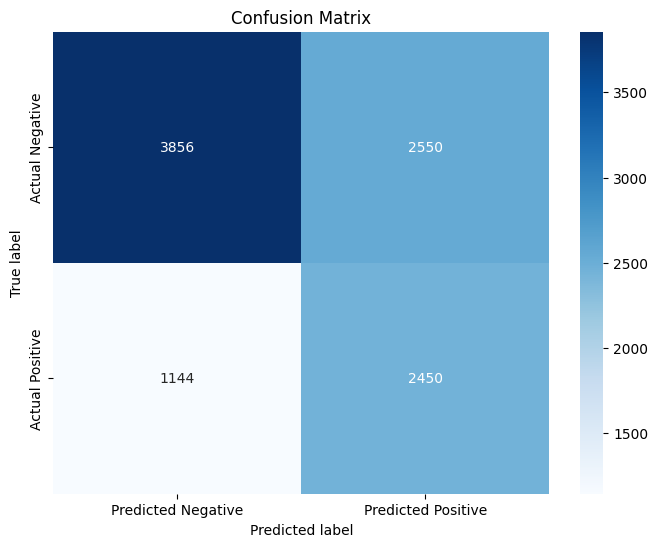

Accuracy: 0.6306
F1-Score: 0.5701652315569002


In [ ]:
print("XGBOOST CLASSIFIER")
print("========================================================")
f1, accuracy = train_model(XGBClassifier(), xtrain_tfidf, y_train, xtest_tfidf, y_test)
print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')

K NEAREST NEIGHBORS


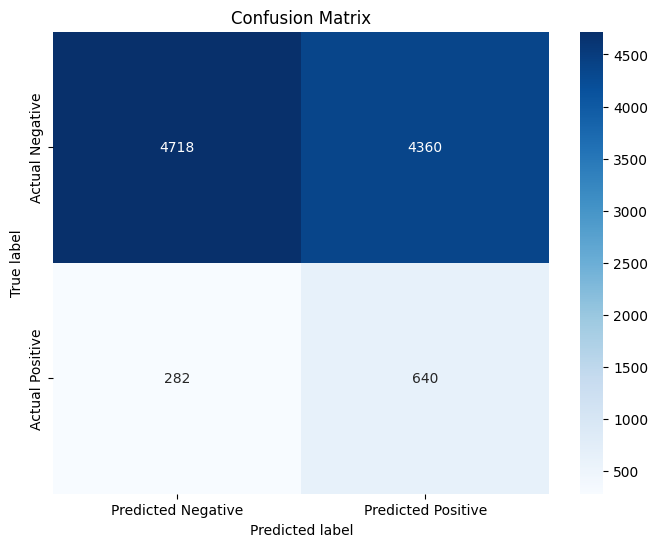

Accuracy: 0.5358
F1-Score: 0.21614319486659914


In [ ]:
print("K NEAREST NEIGHBORS")
print("========================================================")
f1, accuracy = train_model(KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2), xtrain_tfidf, y_train, xtest_tfidf, y_test)
print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')

LOGISTIC REGRESSION


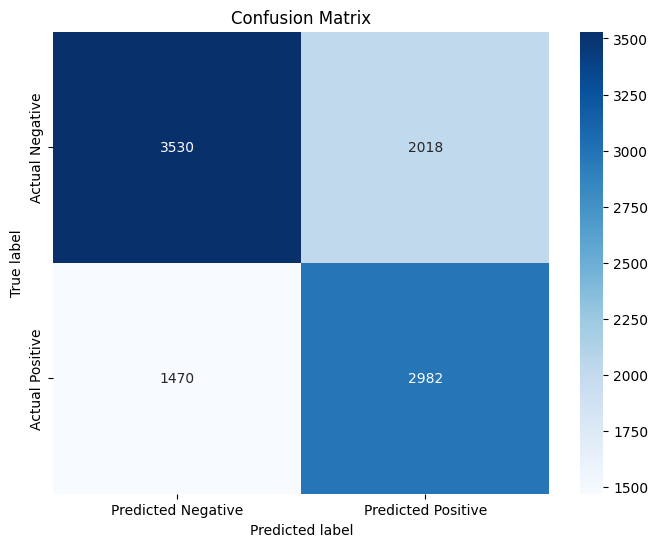

Accuracy: 0.6512
F1-Score: 0.6309775708844689


In [ ]:
print("LOGISTIC REGRESSION")
print("========================================================")
f1, accuracy = train_model(LogisticRegression(solver='lbfgs', max_iter=500), xtrain_tfidf, y_train, xtest_tfidf, y_test)
print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')